In [63]:
# Import all Math tools:
#-----------------------
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
# Figure dpi
dpi = 72

# 1-Dimensional Gaussian Process Regression

## 1) Background:

### Overview of GP
It is a probability distribution over possible functions that model a set of data points.<br>
Interpolation: Spline interpolation outputs a piecewise continuous function composed of polynomials which model the data set.<br>
Regression: In 1D, we have data points and we want to make a prediction of $y$ given $x$. Non-linear polynomial regression outputs a single polynomial that models the entire data set. Higher-degree polynomials give better fits. Problem: only one function best fits the observation. However, if we were supplied with an additional data point, one of the the other possible polynomial functions we could use to model the data set would actually be a better fit. Our solution is to use GP. <br>
Extrapolation: using the regression model to estimate beyond the domain of the sample data.

### Define the Covariance Function
The most commonly used kernel in machine learning is the Gaussian-form radial basis function (RBF) kernel, also known as the squared exponential kernel. The 1D RBF kernel is
$$
    \kappa_\mathrm{rbf}(x,x') = \sigma^2\exp\left(-\frac{(x-x')^2}{2\mathscr{l}^2}\right)
$$
where $\sigma^2$ is the variance and the lengthscale (bandwidth?) parameter is $\mathscr{l}$.

In [107]:
# Construct the 1D RBF kernel:
k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
#Preview the kernel's parameters:
display(k)

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,0.1,+ve,


### Visualize the Kernel
1) Plot the shape of the kernel by plotting $k(x,0)$ over a sample space $x$. If we have a RBF kernel, we should have a Gaussian shape. This plot describes the covaraince between $0$ and a sample point.<br>
2) Construct covariance matrix $K_{xx}$ where 

### Do a Gaussian Process Regression
Let $X$ be the number of sample locations, where each $x$ is a sample location. Let $y=f(x)+\epsilon$ be an observed data point, where $f(x)$ is the function the data is supposed to represent and $\epsilon$ is the noise variable.

In [90]:
def plot_gp(X, m, C, fig, ax, training_points=None, title=" "):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Setup our figure environment
#     fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
#     ax = fig.add_subplot(121)
    
    # Plot 95% confidence interval 
    ax.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    ax.plot(X, m, "-")
    ax.legend(labels=["GP fit"])
    ax.set_xlabel("x"), ax.set_ylabel("f")
    ax.set_title(title)
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        ax.plot(X_, Y_, "kx", mew=2)
        ax.legend(labels=["GP fit", "Sample points"])
        
    # Organize plot
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.5, ls='--')
    ax.grid(which='major', alpha=0.5, ls='--')
    ax.set_xlim(left=0,right=1.05)

Setup

In [376]:
# lambda function, call f(x) to generate data
r = 2
f = lambda x: r*x*(1-x)  #-np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# Number of sample locations
N = 10

# N equally spaced sample locations 
X = np.linspace(0, 1, N)[:,None] #[:,None] turns data into column matrix

# y = f(X) + epsilon
sd = 0.1
Y = f(X) + np.random.normal(0., sd, (N,1)) #np.random.normal takes mean and s.d. (not variance), NOTE: 0.1^2 = 0.01; (N,1) => N-by-1 Matrix

Method 1: Fitting a GP manually

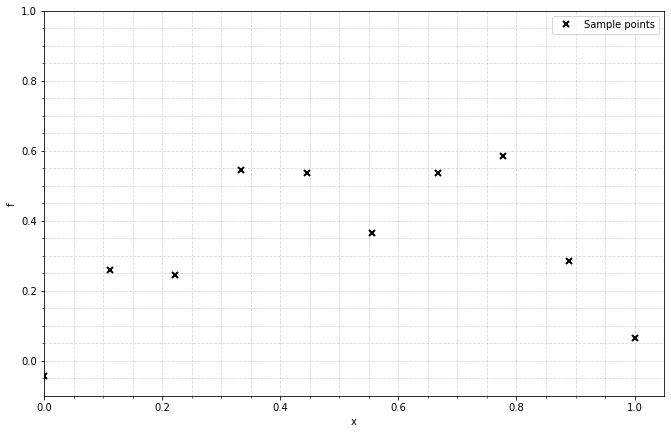

In [377]:
#Plot
#----
# Setup our figure environment
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
# Plot observations
ax.plot(X, Y, "kx", mew=2)
# Annotate plot
ax.set_xlabel("x"), ax.set_ylabel("f")
ax.legend(labels=["Sample points"]);
# Organize plot
ax.minorticks_on()
ax.grid(which='minor', alpha=0.5, ls='--')
ax.grid(which='major', alpha=0.5, ls='--')
# Adjust scales
ax.set_ylim(bottom=-0.1, top=1)
ax.set_xlim(left=0,right=1.05)

plt.subplots_adjust(wspace=0)
plt.show()

In [378]:
# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Covariance between training sample points (+ Gaussian noise)
Kxx = k.K(X,X) + 1 * np.eye(N) #np.eye(N) => N-by-N identity matrix

# Covariance between training and test points
Ksx = k.K(Xnew, X)

# Covariance between test points
Kss = k.K(Xnew,Xnew)

# The mean of the GP fit (note that @ is matrix multiplcation: A @ B is equivalent to np.matmul(A,B))
mean = Ksx @ np.linalg.inv(Kxx) @ Y
# The covariance matrix of the GP fit
Cov = Kss - Ksx @ np.linalg.inv(Kxx) @ Ksx.T

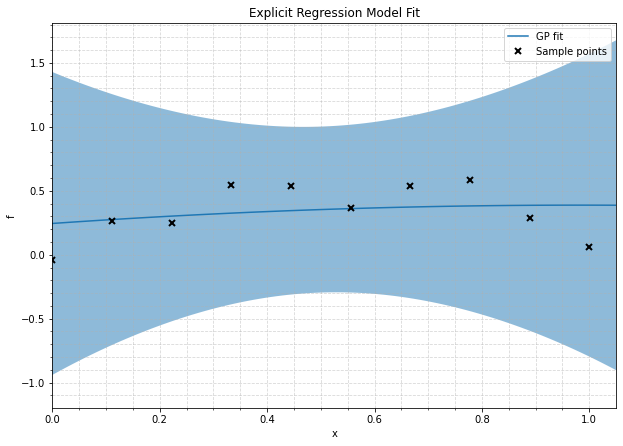

In [379]:
# Plot the GP fit mean and covariance
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y),title="Explicit Regression Model Fit")

Method 2: Doing a GP regression autmatically using GPy.

In [380]:
m = GPy.models.GPRegression(X, Y, k)
m 

GP_regression.,value,constraints,priors
rbf.variance,69546.03204739,+ve,
rbf.lengthscale,13.661498923106272,+ve,
Gaussian_noise.variance,1.0,+ve,


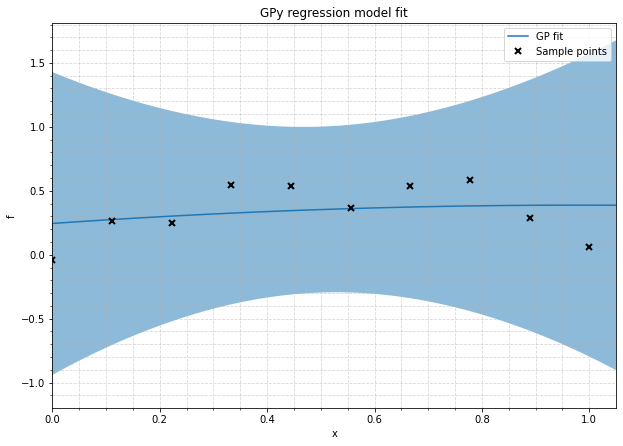

In [381]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew
mean, Cov = m.predict_noiseless(Xnew, full_cov=True) #Predict the underlying function f at the new point(s) Xnew; full_cov - 
#– whether to return the full covariance matrix, or just the diagonal

# Plot the GP fit mean and covariance
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y), title="GPy regression model fit")

GP_regression.,value,constraints,priors
rbf.variance,69546.03204739,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.01,+ve,


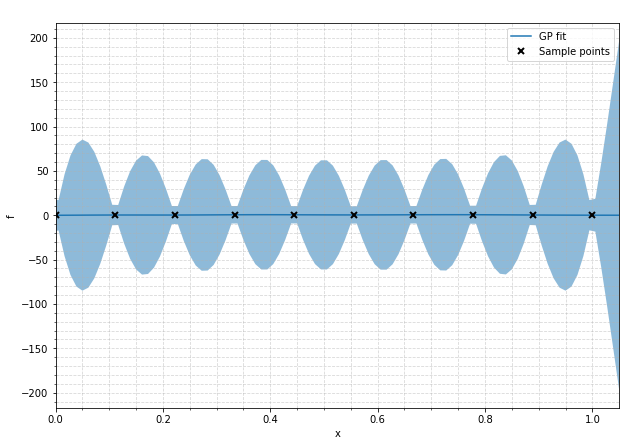

In [382]:
m.Gaussian_noise = 0.01
m.rbf.lengthscale = 0.1

mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Plot the GP fit mean and covariance
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y))

# Preview the regression model
display(m)

### Optimize the Covaraince Function Parameter
We can optimize the estimate of the kernel parameters to give the underlying function the best fit.

In [383]:
m.optimize()
display(m)

GP_regression.,value,constraints,priors
rbf.variance,69546.03162762607,+ve,
rbf.lengthscale,10.945989736473134,+ve,
Gaussian_noise.variance,0.011990780291435155,+ve,


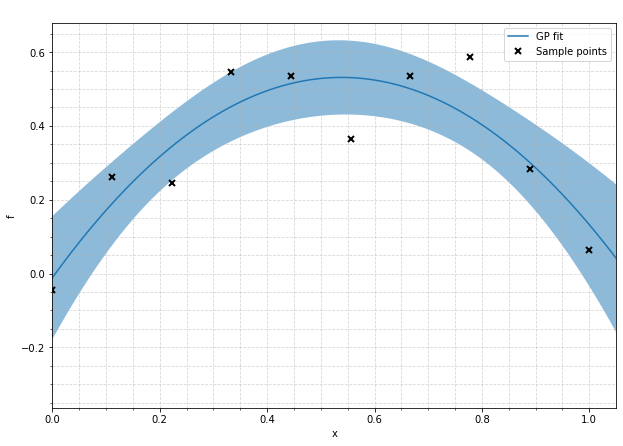

In [384]:
# Update the mean and covariance of the optimized GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

# Plot the GP fit mean and covariance
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y))

Note that the `Gaussian_noise.variance`$=5.608133705933453\times 10^{-9}$. If we know, or can approximate, the variance of the observation noise $\epsilon$, we can fix the optimazation with the GP noise variance of $0.01$ (or whatever it is supposed to be).

In [385]:
# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at sd**2
m.Gaussian_noise.variance = sd**2 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
m

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,69546.03151176454,+ve,
rbf.lengthscale,10.909357251734674,+ve,
Gaussian_noise.variance,0.010000000000000002,fixed +ve,


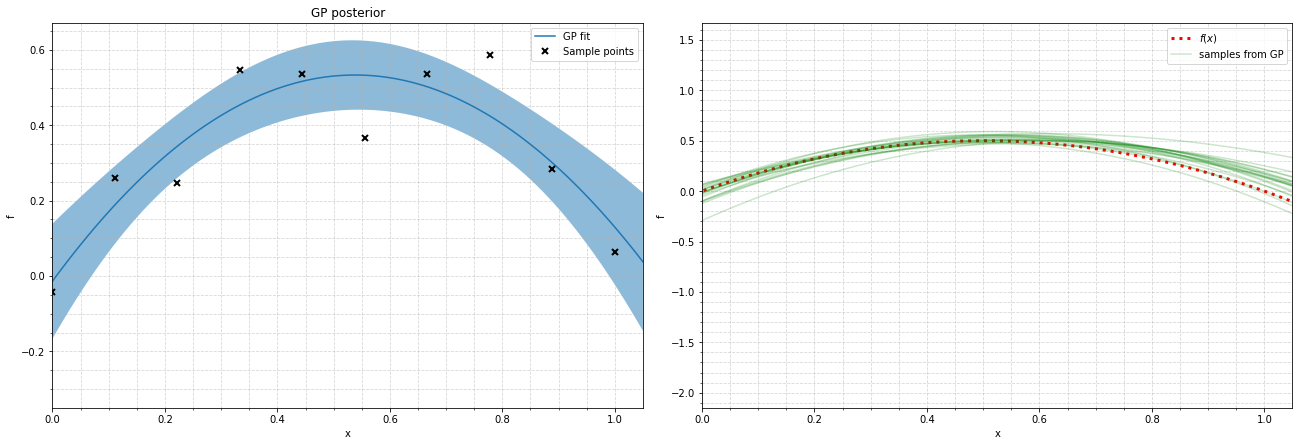

In [386]:
#First Plot
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
# The top plot shows our mean regression fit and 95% confidence intervals 
# Plot the GP fit mean and covariance
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y), title="GP posterior") #posterior probability is the conditional probablity assigned in the light of relevant observations

#Second Plot
ax = fig.add_subplot(122)
ax.plot(Xnew, f(Xnew),"r:", lw=3)
# Sample the GP posterior 20 times from a multivariate Gaussian distribution with mean and covariance obtained from the GP fit.
Z  = np.random.multivariate_normal(mean[:,0], Cov, 20) #the mean vector is 1-D by doing mean[:,0]
for z in Z:
    ax.plot(Xnew,z, "g-", alpha=0.2)
#plot formatting:
ax.minorticks_on()
ax.grid(which='minor', alpha=0.5, ls='--')
ax.grid(which='major', alpha=0.5, ls='--')
ax.set_xlim(left=0,right=1.05)
ax.set_ylim(bottom=-2.15, top=1.67)
ax.set_xlabel("x"), ax.set_ylabel("f")
ax.legend(labels=["$f(x)$", "samples from GP"]);

plt.subplots_adjust(wspace=0.1)
plt.show()

Extrapolating:

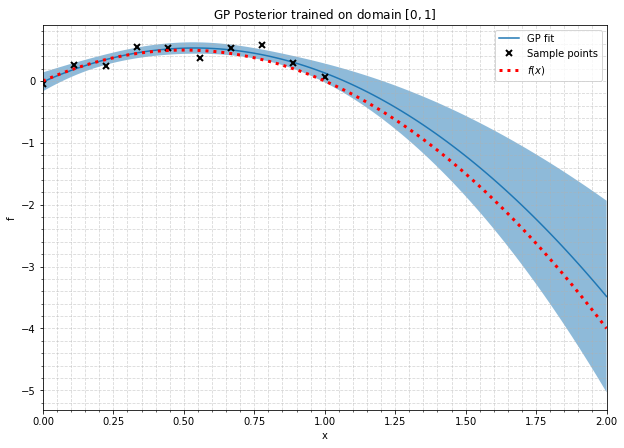

In [387]:
Xnew = np.linspace(0., 2., 100)[:, None]
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y), title="GP Posterior trained on domain $[0,1]$")
plt.plot(Xnew, f(Xnew), "r:", lw=3)
plt.legend(labels=["GP fit", "Sample points", "$f(x)$"])
ax.set_xlim(left=0,right=2);

The GP Posterior Fit:

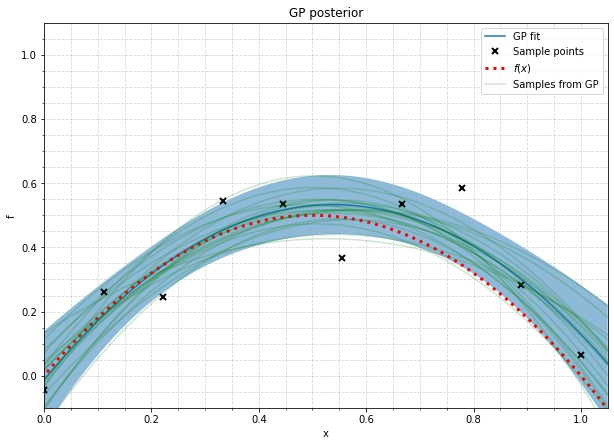

In [388]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]
#First Plot
# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
# The top plot shows our mean regression fit and 95% confidence intervals 
# Plot the GP fit mean and covariance
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
ax.set_ylim(bottom=-0.1, top=1.1)
plot_gp(Xnew, mean, Cov, fig, ax, training_points=(X,Y), title="GP posterior")

#Second Plot On Top
ax.plot(Xnew, f(Xnew),"r:", lw=3)
# Sample the GP posterior 20 times from a multivariate Gaussian distribution with mean and covariance obtained from the GP fit.
Z  = np.random.multivariate_normal(mean[:,0], Cov, 20) #the mean vector is 1-D by doing mean[:,0]
for z in Z:
    ax.plot(Xnew,z, "g-", alpha=0.2)
ax.legend(labels=["GP fit", "Sample points","$f(x)$", "Samples from GP"]);

Resources for GPy coding:
1) https://gpy.readthedocs.io
2) https://linuxtut.com/en/06c94b688ce9a29d346c/